In [37]:
%load_ext autoreload
import trafpy
import trafpy.generator as tpg

import os
import json
import glob

# load demand data
# DATA_NAME = 'ndf50_mldat6e8_university'
# DATA_NAME = 'social_media_cloud_k_4_L_2_n_4_chancap500_numchans1_mldat2e6_bidirectional'
# DATA_NAME = 'pulse_university_mldatNone'
DATA_NAME = 'skewed_nodes_sensitivity_0.2_k_4_L_2_n_16_chancap1250_numchans1_mldat3.2e5_bidirectional'



# path_to_benchmark_data = '/scratch/datasets/trafpy/traces/flowcentric/{}_benchmark_data_v7.json'.format(DATA_NAME)
path_to_benchmark_data = '/scratch/datasets/trafpy/traces/flowcentric/{}_benchmark_data_v13'.format(DATA_NAME)
# path_to_benchmark_data = os.getcwd()+'/../scripts/data2/'


if os.path.isdir(path_to_benchmark_data):
    # data split into separate files in a directory
    separate_files = True
    # load paths to raw benchmark data
    demand_data_list = sorted(glob.glob(path_to_benchmark_data + '/*.json'))
    
else:
    # all data stored in single file
    separate_files = False
    # load raw benchmark data
    benchmark_data = json.loads(tpg.load_data_from_json(path_to_benchmark_data))

# path_to_benchmark_data = '/scratch/datasets/trafpy/traces/flowcentric/{}_benchmark_data.pickle'.format(DATA_NAME)
# benchmark_data = tpg.unpickle_data(path_to_benchmark_data)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
%autoreload
import glob

if not separate_files:
    # organise into list of demand_data dicts
    benchmarks = list(benchmark_data.keys())
    demand_data_list = []
    loads = []
    for benchmark in benchmarks:
        for load in benchmark_data[benchmark]:
            for repeat in benchmark_data[benchmark][load]:
                demand_data = benchmark_data[benchmark][load][repeat]
                demand_data_list.append(demand_data)
                loads.append(load)
    num_sets_of_demand_data = len(demand_data_list)
    print('Number of sets of demand data: {}'.format(num_sets_of_demand_data))
else:
    # stored as separate files, already loaded into list of paths to these files
    pass

In [39]:
# COMPUTE METRICS (NO PLOTTING -> FASTER)

%autoreload
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0}) # disable warnings
from trafpy.generator import Demand, DemandsAnalyser, DemandPlotter, DemandsPlotter

# for plotting
net = tpg.gen_fat_tree(k=4, 
                       L=2, 
                       n=16, 
                       num_channels=1, 
                       server_to_rack_channel_capacity=1250, 
                       rack_to_edge_channel_capacity=1000, 
                       edge_to_agg_channel_capacity=1000, 
                       agg_to_core_channel_capacity=2000, 
                       bidirectional_links=True)
# net = tpg.gen_arbitrary_network(ep_label=None, num_eps=64, num_channels=1, server_to_rack_channel_capacity=50000, bidirectional_links=True)
slot_size = 1e6

# create demand objects and print analysis summary
if not separate_files:
    demands = []
    for demand_data, load in zip(demand_data_list, loads):
        demand = Demand(demand_data, net.graph['endpoints'])
        demands.append(demand)
    analyser = DemandsAnalyser(*demands, job_centric=False)
else:
    analyser = DemandsAnalyser(*demand_data_list, net=net.graph['endpoints'], job_centric=False)
analyser.compute_metrics(print_summary=True)

+----+--------+---------+-------+--------+------------+-------------+--------+------------+-------------+
|    | Name   |   Flows |   1st |   Last |   Duration |        Info |   Load |   Smallest |     Largest |
|----+--------+---------+-------+--------+------------+-------------+--------+------------+-------------|
|  0 | demand |  137435 |     0 | 108666 |     108666 | 3.04265e+09 |  28000 |          1 | 1.70268e+07 |
+----+--------+---------+-------+--------+------------+-------------+--------+------------+-------------+


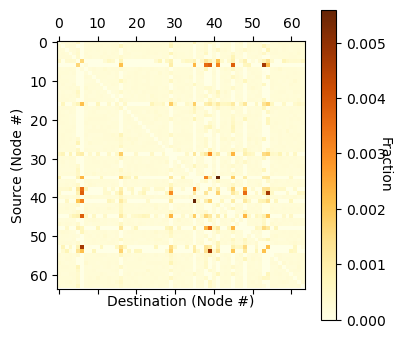

<Figure size 640x480 with 0 Axes>

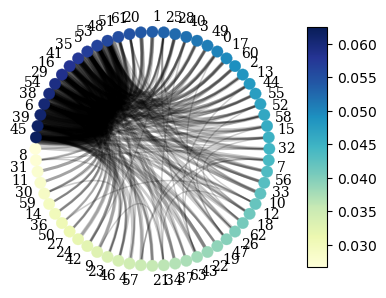

In [40]:
%autoreload
from trafpy.generator import Demand, DemandsAnalyser, DemandPlotter, DemandsPlotter

for demand_data in demand_data_list:
    demand = Demand(demand_data, net.graph['endpoints'])
    plotter = DemandPlotter(demand)
    plotter.plot_node_dist(eps=net.graph['endpoints'],
                           chord_edge_width_range=[1,25],
                           chord_edge_display_threshold=0.06)
#     plotter.plot_node_load_dists(eps=net.graph['endpoints'], ep_link_bandwidth=net.graph['ep_link_capacity'])
#     raise Exception()

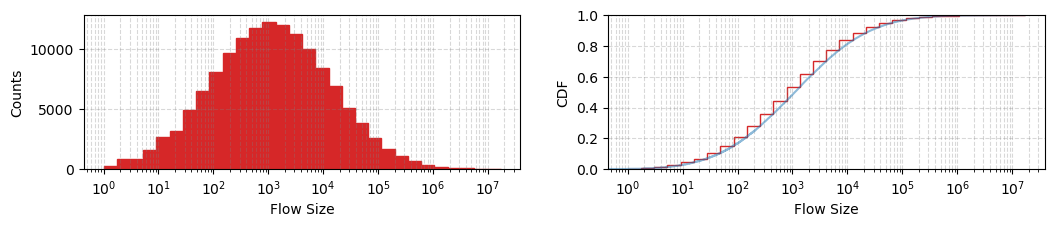

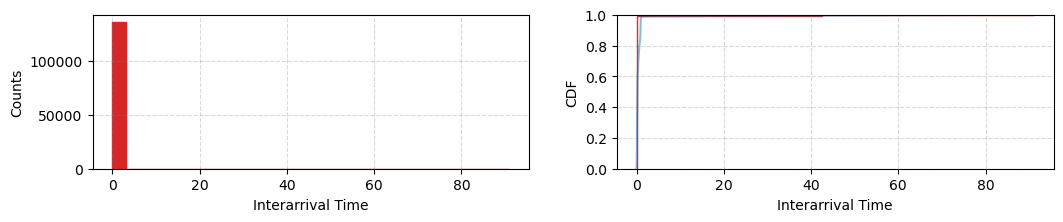

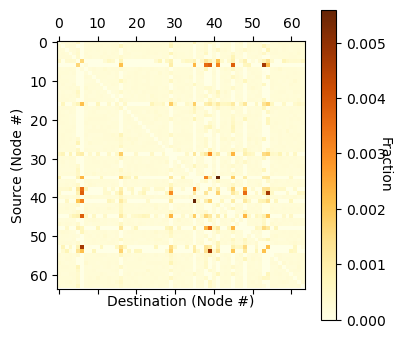

In [ ]:
# COMPUTE METRICS AND PLOTTING

%autoreload
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0}) # disable warnings
from trafpy.generator import Demand, DemandsAnalyser, DemandPlotter, DemandsPlotter

# for plotting
# net = tpg.gen_fat_tree(k=6, L=2, n=10, num_channels=1, server_to_rack_channel_capacity=500, rack_to_edge_channel_capacity=1000, edge_to_agg_channel_capacity=1000, agg_to_core_channel_capacity=2000, bidirectional_links=True)
slot_size = 1e6

# create demand objects and print analysis summary
demands = []
for demand_data in demand_data_list:
    demand = Demand(demand_data, net.graph['endpoints'])
#     demand.name = 'load_{}'.format(load) # name for multi-plot legend(s)
    if not separate_files:
        demands.append(demand)
    plotter = DemandPlotter(demand)
    plotter.plot_flow_size_dist(logscale=True, num_bins=30)
    plotter.plot_interarrival_time_dist(logscale=False, num_bins=30)
    plotter.plot_node_dist(eps=net.graph['endpoints'],
                           chord_edge_width_range=[1,25],
                           chord_edge_display_threshold=0.045)
    plotter.plot_node_load_dists(eps=net.graph['endpoints'], 
                                 ep_link_bandwidth=net.graph['ep_link_capacity'])
#     plotter.plot_node_load_dists(eps=net.graph['endpoints'], ep_link_bandwidth=500)
#     plotter.plot_link_loads_vs_time(net, slot_size, demand, mean_period='all')
if not separate_files:
    analyser = DemandsAnalyser(*demands, job_centric=False)
else:
    analyser = DemandsAnalyser(*demand_data_list, net=net.graph['endpoints'], job_centric=False)
analyser.compute_metrics(print_summary=True)

if not separate_files:
    plotters = DemandsPlotter(*demands)
else:
    plotters = DemandsPlotter(*demand_data_list, net=net.graph['endpoints'])
_ = plotters.plot_flow_size_dists(logscale=False)
_ = plotters.plot_interarrival_time_dists(logscale=False)

In [6]:
%autoreload
for demand_data, load in zip(demand_data_list, loads):
    plotter.plot_node_dist(eps=net.graph['endpoints'],
                           chord_edge_width_range=[1,25],
                           chord_edge_display_threshold=0)

NameError: name 'loads' is not defined

In [ ]:
print(demand.num_demands)
print(len(demand['flow_id']))

In [ ]:
_ = plotters.plot_link_loads_vs_time_for_different_loads(logscale=False)

In [ ]:
%autoreload
print('Keys of first demand data set:\n{}'.format(demand_data_list[0].keys()))
# print('\nStructure of first demand data set:\n{}'.format(demand_data_list[0]))

In [ ]:
%autoreload
for benchmark in benchmarks:
    print(benchmark_data[benchmark].keys())
    for load in list(benchmark_data[benchmark].keys()):
        for repeat in benchmark_data[benchmark][load]:
            print('benchmark: {} | load: {} | repeat: {}'.format(benchmark,load,repeat))

In [ ]:
%autoreload
from trafpy.generator import Demand
import sys
import json

demand = Demand(demand_data_list[-1])
for SLOT_SIZE in [1e4]:
    slots_dict = demand.get_slots_dict(SLOT_SIZE, print_info=True)

In [ ]:
slots_dict[0]